<a href="https://colab.research.google.com/github/rafajacomel/phd_ita/blob/main/olist_pytorch_sentiment_analysis_bi_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is part of the PhD thesis of Rafael Medeiros Jacomel de Oliveira Silva at Technological Institute of Aeronautics (ITA) This code uses a Long short-term memory Network to classify sentiments in positive and negative.We use Brazilian E-Commerce Public Dataset by Olist datasatet (https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) which can be confiured on DATA_HUB['olist_data_dir'] and glove embeddings (http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc) which can be congigures on DATA_HUB['data_dir_glove'] and DATA_HUB['glove_file'].

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
DATA_HUB = dict()
DATA_HUB['olist_data_dir'] ='/content/sample_data/olist_order_reviews_dataset.csv'
DATA_HUB['data_dir_glove'] = '/content/drive/MyDrive/portuguese_glove_s100/'
DATA_HUB['glove_file'] = 'glove_s100.txt'

import collections
import hashlib
import inspect
import math
import os
import random
import re
import shutil
import sys
import tarfile
import time
import zipfile
from collections import defaultdict
import pandas as pd
import requests
from IPython import display
from matplotlib import pyplot as plt

import numpy as np
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

phd = sys.modules[__name__]
nn_Module = nn.Module

import collections
import hashlib
import inspect
import math
import os
import random
import re
import shutil
import sys
import tarfile
import time
import zipfile
from collections import defaultdict
import pandas as pd
import requests
from IPython import display
from matplotlib import pyplot as plt

phd = sys.modules[__name__]

import numpy as np
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

nn_Module = nn.Module
ones_like = torch.ones_like
ones = torch.ones
zeros_like = torch.zeros_like
zeros = torch.zeros
tensor = torch.tensor
arange = torch.arange
meshgrid = torch.meshgrid
sin = torch.sin
sinh = torch.sinh
cos = torch.cos
cosh = torch.cosh
tanh = torch.tanh
linspace = torch.linspace
exp = torch.exp
log = torch.log
normal = torch.normal
rand = torch.rand
randn = torch.randn
matmul = torch.matmul
int32 = torch.int32
int64 = torch.int64
float32 = torch.float32
concat = torch.cat
stack = torch.stack
abs = torch.abs
eye = torch.eye
sigmoid = torch.sigmoid
batch_matmul = torch.bmm
numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
transpose = lambda x, *args, **kwargs: x.t(*args, **kwargs)
reduce_mean = lambda x, *args, **kwargs: x.mean(*args, **kwargs)
expand_dims = lambda x, *args, **kwargs: x.unsqueeze(*args, **kwargs)
swapaxes = lambda x, *args, **kwargs: x.swapaxes(*args, **kwargs)
repeat = lambda x, *args, **kwargs: x.repeat(*args, **kwargs)

In [39]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

In [40]:
def use_svg_display():
    """Use the svg format to display a plot in Jupyter.
    Defined in :numref:`sec_calculus`"""
    display.set_matplotlib_formats('svg')

In [41]:
def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib.
    Defined in :numref:`sec_calculus`"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

In [42]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [43]:
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [44]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()


    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]


    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)


    def sum(self):
        """Return the sum of time."""
        return sum(self.times)


    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [46]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [47]:
import collections
import re

In [48]:
def tokenize(lines, token='word'):
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

In [49]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        """Defined in :numref:`sec_text_preprocessing`"""
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]


    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

In [50]:
class TokenEmbedding:
    """Token Embedding."""
    def __init__(self):
        """Defined in :numref:`sec_synonyms`"""
        self.idx_to_token, self.idx_to_vec = self._load_embedding()
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self):
        idx_to_token, idx_to_vec = ['<unk>'], []
        #data_dir = download_extract(embedding_name)
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        data_dir_glove = DATA_HUB['data_dir_glove']
        glove_file = DATA_HUB['glove_file']
        with open(os.path.join(data_dir_glove, glove_file), 'r', encoding="utf8") as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [51]:
def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [52]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

In [53]:
from torch.utils import data
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator.
    Defined in :numref:`sec_linear_concise`"""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [54]:
import pandas as pd
import numpy as np

In [55]:
def read_olist(data_dir, is_train):
    df = pd.read_csv(data_dir)
    data, labels = [], []
    for index, row in df.iterrows():

        if((not(pd.isnull(row['review_comment_message']))
            and (not(pd.isnull(row['review_score']))))):
            if(row['review_score'] == 1
               or  row['review_score'] == 2
               or row['review_score'] == 3):
                data.append(row['review_comment_message'])
                labels.append(0)
            else:
                data.append(row['review_comment_message'])
                labels.append(1)

    cut_index=int(len(data)/3)

    if (is_train):
        return data[cut_index:], labels[cut_index:]
    else:
        return data[0:cut_index], labels[0:cut_index]

In [56]:
def load_data_olist(batch_size, num_steps=500):
    olist_data_dir = DATA_HUB['olist_data_dir']
    train_data = read_olist(olist_data_dir, True)
    test_data = read_olist(olist_data_dir, False)
    train_tokens = tokenize(train_data[0], token='word')
    test_tokens = tokenize(test_data[0], token='word')
    vocab = Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])

    train_iter = load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)


    return train_iter, test_iter, vocab

In [57]:
import torch
import time
from torch import nn

In [58]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu().

    Defined in :numref:`sec_use_gpu`"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [59]:
def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists.

    Defined in :numref:`sec_use_gpu`"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [60]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

In [61]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()


    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]


    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)


    def sum(self):
        """Return the sum of time."""
        return sum(self.times)


    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [62]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [63]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]


    def reset(self):
        self.data = [0.0] * len(self.data)


    def __getitem__(self, idx):
        return self.data[idx]

In [64]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions.

    Defined in :numref:`sec_softmax_scratch`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = torch.argmax(y_hat, axis=1)
    cmp =  astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))

In [65]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [66]:
def train_net(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=try_all_gpus()):
    """Train a model with mutiple GPUs (defined in Chapter 13).

    Defined in :numref:`sec_image_augmentation`"""
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [67]:
def train_batch(net, X, y, loss, trainer, devices):
    """Train for a minibatch with mutiple GPUs (defined in Chapter 13).

    Defined in :numref:`sec_image_augmentation`"""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [68]:
import torch
from torch import nn

In [70]:
batch_size = 64
train_iter, test_iter, vocab = load_data_olist(batch_size)

In [71]:
class BI_LSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BI_LSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [72]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 4, try_all_gpus()
net = BI_LSTM(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
net.apply(init_weights);

In [73]:
glove_embedding = TokenEmbedding()

In [ ]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([4206, 100])

loss 0.206, train acc 0.928, test acc 0.881
16.8 examples/sec on [device(type='cpu')]


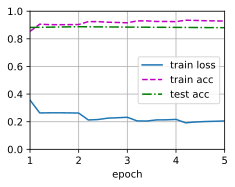

In [74]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train_net(net, train_iter, test_iter, loss, trainer, num_epochs, devices)